In [1]:
%load_ext autoreload
%autoreload 1

%aimport src.utils.tardisml_utils

In [2]:
%reload_ext autoreload

In [3]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

from src.data_preparation import mdl_dataset_prep as dataset_prep

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
import src.visualization.visualize_error as visualize_error

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

fram detected
fram detected
fram detected
fram detected
fram detected


In [4]:
# Date to plot in example
idate = 100
# Path to config file
file_config = '../config/data_proc_demo.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config, verbose=True)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)
ml_model, nseq, params = load_config.load_ml_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881
Config file updated (pca_dir): ../config/data_proc_demo.yaml
Config file updated: ../config/data_proc_demo.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/rf_Npred30_4F_rw21d_N8888_H2211_Hn0000_hice00_artc
Folder created



In [5]:
# copy config file to results
!cp {file_config} {rootdir+res_dir}

- mslprs: Mean sea-level pressure
- airtmp: Air temperature

## Define chronology

In [6]:
# The chronology is the same for all forcing fields
# Just take the first one

# df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'{forcing_fields[0]}.pkl'))
df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'mslprs.pkl'))
chrono = df[df.time%1==timeofday].date

chrono.iloc[idate]

Timestamp('2014-04-11 12:00:00')

## Get land mask

In [7]:
mskok1d, mskok = load_data.get_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)

## Construct train/val/test dataset

#### Loading Target var PCA WITHOUT SIT assimilation

In [8]:
data_kind = "nosit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_noSITass.pkl")
pca_f = load_data.load_pca(filename)

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hice00_8N_noSITass.pkl



In [9]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_noSITass.nc")
Xf, mu_f, RMSE_f = load_data.load_nc(filename, target_field)

In [10]:
# retrieve PC and EOF values
PCs_f = feature_pca.pca_to_PC(pca_f, Xf, mskok1d)

EOF1d_f, EOF2d_f = feature_pca.compute_eof(n_components, Xf, pca_f, mskok)

In [11]:
# Reconstruction from PCA
Xf_rec = xr.dot(EOF2d_f,PCs_f) + mu_f

# RMSE for comparison with RMSE predicted by ML
RMSE_recf = np.sqrt((np.square(Xf_rec-Xf)).mean(dim='rdim'))

---

#### Loading ERROR of Target var PCA SIT assimilation - no assimilation

In [12]:
data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_SITerr.pkl")
pca_e = load_data.load_pca(filename)

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hice00_8N_SITerr.pkl



In [13]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITerr.nc")
Xe, mu_e, RMSE_e = load_data.load_nc(filename, target_field)

In [14]:
# retrieve PC and EOF values
PCs_e = feature_pca.pca_to_PC(pca_e, Xe, mskok1d)

EOF1d_e, EOF2d_e = feature_pca.compute_eof(n_components, Xe, pca_e, mskok)

In [15]:
# Reconstruction from PCA
Xe_rec = xr.dot(EOF2d_e,PCs_e) + mu_e

# RMSE for comparison with RMSE predicted by ML
RMSE_rece = np.sqrt((np.square(Xe_rec-Xe)).mean(dim='rdim'))

---

#### Loading covariable PCA - noSIT assimilation
that could help the sea-ice thickness prediction such as:

- fice: fraction of sea ice
- hsnow: snowdepth
- age ice

In [16]:
data_kind = "covariable"
n_components = load_config.get_n_components(data_kind, file_config)

In [17]:
PCs_co = load_data.load_covariables(covar_fields, mskok1d, pca_dir, n_components)

Retrieve fice00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_fice00_8N_noSITass.pkl

Retrieve hsnw00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hsnw00_8N_noSITass.pkl



#### Loading forcings PCA

In [18]:
data_kind = "forcing"
filename = load_config.get_pca_filename(data_kind, file_config, pca_dir)

In [19]:
PCs, EOFs = load_data.load_forcing_PC_EOF(filename, forcing_bdir, forcing_fields)

Loading forcing values
Loading pca
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_airtmp-mslprs-vapmix-precip_8N_21d.pkl

Retrieve PCs and EOFs


- --

### Preparing the dataset

- --

In [20]:
from src.data_preparation.mdl_dataset_prep import target_history # as target_history


In [21]:
# 3 types of predictors
# Xtp: The same as the target at t+1, (t+2, t+3, ...)
# Xnc: Forecast for the non corrected model at time t, (t-N, ..., t+N)
# Xfo: forcings at t (t-N, ..., t+N)
# Xco: covariables from the non corrected model at time t, (t-N, ..., t+N)
# We invert the time axis

# H = 4  # Xtp
H = params['History'][params['type_var_short'].index('tp')]
H_neg = params['History_neg'][params['type_var_short'].index('tp')]
Xtp, nhypfeat, hyplabels = target_history(PCs_e.values[::-1], H, H_neg, f'Xe', False)  # 'PCa'


# Hnc = 2  # 0  # Xnc
Hnc = params['History'][params['type_var_short'].index('nc')]
Hnc_neg = params['History_neg'][params['type_var_short'].index('nc')]
Xnc, _, nclabels = target_history(PCs_f.values[::-1], Hnc, Hnc_neg, 'SITf')  # 'PCna'


# Hfo = 1  # Xfo
Hfo = params['History'][params['type_var_short'].index('fo')]
Hfo_neg = params['History_neg'][params['type_var_short'].index('fo')]
folabels = []
# Xfo  = np.concatenate([PCs[field] for field in forcing_fields],axis=1)[::-1][:-1]

for idx, field in enumerate(forcing_fields):
    fotmp, _, folab = target_history(PCs[field][::-1], Hfo, Hfo_neg, field[:6])
    folabels += folab
    if idx == 0:  # field == forcing_fields[0]:
        Xfo = fotmp
        continue
    Xfo = np.hstack([Xfo, fotmp])
    

# covariable Xco
# Hco = 1
Hco = params['History'][params['type_var_short'].index('co')]
Hco_neg = params['History_neg'][params['type_var_short'].index('co')]
colabels = []

for idx, covar in enumerate(covar_fields):
    cotmp, _, colab = target_history(PCs_co[covar][::-1], Hco, Hco_neg, covar[:6])
    colabels += colab
    if idx == 0:  # field == forcing_fields[0]:
        Xco = cotmp
        continue
    Xco = np.hstack([Xco, cotmp])

# without covariables
# X = np.concatenate((Xtp, Xnc, Xfo),axis=1)
# totlabels = hyplabels + nclabels + folabels

# with covariables
X = np.concatenate((Xtp, Xnc, Xfo, Xco),axis=1)
totlabels = hyplabels + nclabels + folabels + colabels

# without Xtp
# X = np.concatenate((Xnc, Xfo, Xco),axis=1)
# totlabels = nclabels + folabels + colabels

# without forcing
# X = np.concatenate((Xtp, Xnc),axis=1)
# totlabels = hyplabels + nclabels



y = PCs_e.values[::-1][1:]  # target var t

In [22]:
print('todo: do a function to get params H and H negative')

todo: do a function to get params H and H negative


In [23]:
covar_fields

['fice00', 'hsnw00']

#### Split the dataset

In [24]:
ntest, nval, ntrain, nsplit = dataset_prep.compute_dataset_splits(y)
print(f'Number of split for CV: {nsplit}')

Number of split for CV: 3


In [25]:
# %%capture cap --no-stderr

Xtrain, ytrain = X[:ntrain+nval], y[:ntrain+nval]

print(f'Size of the training set:   {ntrain} days')
print(f'Size of the validation set: {nval}')
print(f'\nSize of the test set:       {ntest}')

Size of the training set:   735 days
Size of the validation set: 360

Size of the test set:       365


In [26]:
# from src.modelling. model_utils import add_output_2txt
# add_output_2txt(fl_out, cap)  # save output to .txt file
# print(cap)

#### Addition of noise

In [27]:
# Add some noise to the Xtp feature to avoid overfitting
nfeat = Xtp.shape[1] // (H+H_neg+1)
nhyperfeat = Xtp.shape[1]

Xtrain, noise = dataset_prep.add_noise(Xtrain, nhyperfeat, pert=1)


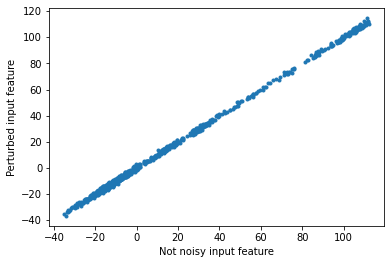

In [28]:
ch = 0
plt.plot(Xtrain[:,ch] - noise[:,ch], Xtrain[:,ch],'.')
plt.xlabel('Not noisy input feature')
plt.ylabel('Perturbed input feature');

In [29]:
X[:ntrain+nval].shape

(1095, 144)

In [30]:
print('ML is given the following inputs:')
totlabels[::nfeat]

ML is given the following inputs:


['Xe t+1',
 'Xe t+2',
 'Xe t+3',
 'SITf t+0',
 'SITf t+1',
 'SITf t+2',
 'airtmp t+0',
 'airtmp t+1',
 'mslprs t+0',
 'mslprs t+1',
 'vapmix t+0',
 'vapmix t+1',
 'precip t+0',
 'precip t+1',
 'fice00 t+0',
 'fice00 t+1',
 'hsnw00 t+0',
 'hsnw00 t+1']

## A first simple model

In [31]:
from sklearn.model_selection import TimeSeriesSplit

from src.visualization.time_serie_split import PlotTimeSerieSplit

In [32]:
max_test_size = int(Xtrain.shape[0]/(nsplit +1))

In [33]:
ts_cv = TimeSeriesSplit(
    n_splits=nsplit,
    gap=0,
    max_train_size=ntrain,
   test_size=max_test_size,
)
# test_size = nval -> train dataset too small for the first split

In [34]:
PlotTimeSerieSplit(ts_cv, Xtrain, chrono, rootdir+fig_dir, True, False)

Png saved as : /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/ML_TimeSerieSplit.png


----

In [35]:
from src.modelling import model_ridge
from src.modelling import model_rf
from src.modelling import model_grdbst
# from src.modelling import model_lstm


from src.modelling import model_utils

ml_classes = [model_ridge, model_rf, model_grdbst]  # , model_lstm]  # etc
ml_classes_name = ['model_ridge', 'model_rf', 'model_grdbst']  # , 'model_lstm']

In [36]:
# to load a specific model
# m1 = model_grdbst.ModelML(nfeat)
# m1.load('path/to/model/model_grdbst.joblib')  # or .save ?

In [37]:
# pick the corresponding machine learning model
ml_idx = [i for i, cl in enumerate(ml_classes_name) if ml_model in cl][0]

In [38]:
m1 = ml_classes[ml_idx].ModelML(nfeat, ntest, ntrain, totlabels, rootdir, ml_dir, fig_dir)

m1.generate_model()
m1.clf

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [39]:
if ml_model == 'ridge':
#     param_grid = {'ridge__alpha':[1e-3, 1e-2, 1e-1, 1, 10], 'ridge__random_state':[4410]}
    param_grid = {'ridge__alpha':[1e-3, 1e-2, 1e-1, 1, 10], 'ridge__random_state':[0]}
elif ml_model == 'rf':
#     param_grid = {'randomforestregressor__n_estimators': [100,200],'randomforestregressor__max_depth':[5,10,20,50], 'randomforestregressor__min_impurity_decrease':[0,0.1],'randomforestregressor__bootstrap':[True],'randomforestregressor__min_samples_leaf':[10], 'randomforestregressor__min_samples_split':[2,3]}
#     param_grid = {'randomforestregressor__bootstrap': [True], 'randomforestregressor__min_impurity_decrease': [0], 'randomforestregressor__min_samples_leaf': [1], 'randomforestregressor__min_samples_split': [3], 'randomforestregressor__n_estimators': [200]}
    param_grid = {'randomforestregressor__random_state':[0], 'randomforestregressor__bootstrap': [True], 'randomforestregressor__min_impurity_decrease': [0], 'randomforestregressor__min_samples_leaf': [1], 'randomforestregressor__min_samples_split': [3], 'randomforestregressor__n_estimators': [200]}
elif ml_model == 'grdbst':
#     param_grid = {'gradientboostingregressor__random_state':[0]}
    param_grid = {'gradientboostingregressor__random_state':[0], 'gradientboostingregressor__loss':['squared_error'],'gradientboostingregressor__min_impurity_decrease': [0], 'gradientboostingregressor__min_samples_leaf': [1], 'gradientboostingregressor__min_samples_split': [3], 'gradientboostingregressor__n_estimators': [200]}
    # best with n_estimators = 100 overall

In [40]:
m1.gridCV(param_grid, ts_cv)

In [41]:
m1.fit(Xtrain, ytrain)

In [42]:
m1.predict(X, y)

In [43]:
m1.eval_grid_cv()



CV results:
{'mean_fit_time': array([5.81830883]),
 'mean_score_time': array([0.02454734]),
 'mean_test_score': array([-2.70996273]),
 'param_randomforestregressor__bootstrap': masked_array(data=[True],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_randomforestregressor__min_impurity_decrease': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_randomforestregressor__min_samples_leaf': masked_array(data=[1],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_randomforestregressor__min_samples_split': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_randomforestregressor__n_estimators': masked_array(data=[200],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_randomforestregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value=

In [44]:
m1.cv_score()

Mean Absolute Error:     23.523 +/- 23.443
R2:     -0.273 +/- 1.080
Root Mean Squared Error: 29.772 +/- 26.487


### Save best estimator ML for later use

In [45]:
m1.save_best_est()

ML model saved as:
/nird/projects/nird/NS2993K/Leo/results/rf_Npred30_4F_rw21d_N8888_H2211_Hn0000_hice00_artc/ml/rf_bootstrap_True_decrease_0_leaf_1_split_3_estimators_200_state_0.joblib


### Recursive prediction

In [48]:
m1.H = H

In [49]:
m1.recursive_prediction(X, y)

todo: put that in a script in src/modelling/recursive_prediction.py
recursive 2
recursive for History
recursive for History
[-14.35557084  15.88611043  -8.6615783   -6.95827278 -11.18296418
 -16.69023518  -6.29453946  -2.86592069]
recursive 3
recursive for History
recursive for History
[-14.54864679  14.6220505   -7.12229778  -7.57733942 -11.17533512
 -15.56963477  -6.51596344  -2.00615018]
recursive 4
recursive for History
recursive for History
[-14.42648941  16.60047819  -8.55239504  -7.17848759 -11.26719331
 -16.64205764  -6.17960488  -2.70157634]
recursive 5
recursive for History
recursive for History
[-15.7435409   17.58162487  -8.48146379  -7.29957786 -10.2237242
 -15.55845977  -6.21598148  -1.85672188]
recursive 6
recursive for History
recursive for History
[-16.17231419  18.04412567  -8.56403644  -7.21433261 -10.15527783
 -15.28757642  -6.0476737   -1.46517904]
recursive 7
recursive for History
recursive for History
[-16.34855915  18.35354316  -8.70668981  -7.10996006 -10.34790

recursive 54
recursive for History
recursive for History
[-10.06187095  32.83880115  -6.52653708  -0.95798557  -0.59132657
 -15.5466799    2.51833816 -13.94885478]
recursive 55
recursive for History
recursive for History
[-10.13722052  33.18857671  -6.93849622  -0.50256378  -0.04427511
 -15.74025849   2.52802664 -14.11632486]
recursive 56
recursive for History
recursive for History
[-1.00796295e+01  3.33949146e+01 -6.85705319e+00 -3.72625587e-01
  2.41455566e-02 -1.59322190e+01  2.54648592e+00 -1.44089176e+01]
recursive 57
recursive for History
recursive for History
[ -9.99846528  33.64690017  -6.65427041  -0.29453315  -0.05991667
 -16.20232464   2.54071476 -14.79355772]
recursive 58
recursive for History
recursive for History
[ -9.88469701  34.03463632  -6.41667452  -0.18741011  -0.13062176
 -16.50071506   2.5242217  -15.21870345]
recursive 59
recursive for History
recursive for History
[ -9.8308742   34.25316039  -6.37325574  -0.06229259  -0.03744977
 -16.63302542   2.51059436 -15.35

recursive 108
recursive for History
recursive for History
[-16.62348598  27.36680332  -7.45529011   7.91925164  19.42209263
 -17.10010474   1.04414974  -6.91315706]
recursive 109
recursive for History
recursive for History
[-16.59908057  27.12115684  -7.16139545   8.01051468  19.46037089
 -16.90288504   1.06098486  -6.68886673]
recursive 110
recursive for History
recursive for History
[-16.38647041  26.50860573  -6.16661456   8.14801681  19.42573636
 -16.46619729   1.2396483   -5.95620508]
recursive 111
recursive for History
recursive for History
[-16.33902248  26.29942441  -5.85875273   8.20614506  19.43406113
 -16.31596543   1.31868737  -5.74784228]
recursive 112
recursive for History
recursive for History
[-16.30696709  26.13809952  -5.68340678   8.22776581  19.47171674
 -16.06495498   1.36454823  -5.69431707]
recursive 113
recursive for History
recursive for History
[-16.28432705  25.97962614  -5.45034512   8.25616249  19.50787707
 -15.91977818   1.45704624  -5.61308249]
recursive 

recursive 163
recursive for History
recursive for History
[-14.29508706  27.7168148   14.38283731  17.23404598  14.17561189
  -4.15481308  -0.26540142  -0.77150966]
recursive 164
recursive for History
recursive for History
[-14.00847413  27.60139565  14.56885981  17.4023646   14.04009404
  -4.16109927  -0.33658352  -0.61056145]
recursive 165
recursive for History
recursive for History
[-13.57954347  27.46608963  15.04179874  17.69912803  13.80511643
  -3.9862579   -0.52715738  -0.32521723]
recursive 166
recursive for History
recursive for History
[-12.36348153  27.21555161  16.81192127  18.33771248  13.07751345
  -3.35054955  -1.08106798   0.44061076]
recursive 167
recursive for History
recursive for History
[-12.07431388  27.20600804  17.20054849  18.59085863  12.88875851
  -3.21440141  -1.20121935   0.6438511 ]
recursive 168
recursive for History
recursive for History
[-11.77963874  27.33337186  17.50932108  18.95126744  12.64933351
  -3.19639128  -1.30952538   0.8135024 ]
recursive 

recursive 217
recursive for History
recursive for History
[-1.52959298 20.31660655 32.05864094 41.33119213  2.17975335  7.3189607
  8.23212201  3.85108912]
recursive 218
recursive for History
recursive for History
[-1.61894204 20.41307639 32.28345195 41.45871968  2.17621611  7.36206309
  8.49626553  3.91401474]
recursive 219
recursive for History
recursive for History
[-1.65992666 20.51100105 32.51796371 41.90458898  2.09168752  7.60766838
  8.94237819  4.06089038]
recursive 220
recursive for History
recursive for History
[-1.67115662 20.61319733 32.71619266 42.33948752  1.87304949  7.98490692
  9.34007768  4.21115614]
recursive 221
recursive for History
recursive for History
[-1.623952   20.63602579 33.07649702 42.61337789  1.69624764  8.18879677
  9.62200628  4.44059366]
recursive 222
recursive for History
recursive for History
[-1.20012033 20.5818992  34.17310912 43.3857812   1.34436341  8.32286341
 10.18565858  5.07083839]
recursive 223
recursive for History
recursive for History
[

recursive 272
recursive for History
recursive for History
[-6.05479135 20.82037465 42.43091713 29.33667904  4.49480462  7.00865294
 12.80038647  7.82225804]
recursive 273
recursive for History
recursive for History
[-5.92622194 20.90605455 42.66210124 29.02603758  4.22296026  6.962785
 12.84507647  8.02573475]
recursive 274
recursive for History
recursive for History
[-5.74782662 20.97362704 42.93130711 28.65820933  3.70848088  6.86842493
 12.89568215  8.28736727]
recursive 275
recursive for History
recursive for History
[-5.59780238 21.05387843 43.24288847 28.01990969  3.02513555  6.66117272
 12.84389195  8.57697573]
recursive 276
recursive for History
recursive for History
[-5.45981876 21.07350183 43.50355678 27.5157122   2.33389876  6.46234973
 12.80507996  8.86518217]
recursive 277
recursive for History
recursive for History
[-5.27397203 21.0530352  43.23429707 26.1281123   1.88325575  5.79898343
 12.40193913  9.03445743]
recursive 278
recursive for History
recursive for History
[-

recursive 327
recursive for History
recursive for History
[-11.65478901  14.85135165  47.57014324 -10.10652246 -14.71442306
  -5.10365694  -8.26741008   4.49103623]
recursive 328
recursive for History
recursive for History
[-12.473478    14.821485    47.52963039 -10.87719733 -14.45900297
  -5.19832072  -8.59731548   3.85587118]
recursive 329
recursive for History
recursive for History
[-12.29143794  14.58932591  48.00306803 -11.39626261 -14.55443309
  -5.06576821  -8.90028534   3.88906043]
recursive 330
recursive for History
recursive for History
[-12.11983122  14.34678105  48.73024689 -12.00010929 -14.77058436
  -5.01558047  -9.30789784   4.05641289]
recursive 331
recursive for History
recursive for History
[-11.88563808  14.16706504  49.22355542 -12.37086327 -14.82842943
  -4.96514799  -9.47034139   4.20000635]
recursive 332
recursive for History
recursive for History
[-11.72812393  14.11158181  49.53502917 -12.4928182  -14.91391448
  -5.04696313  -9.70971344   4.28411412]
recursive 

recursive 381
recursive for History
recursive for History
[ -9.41921634  -0.19781478  51.28807901 -34.32433081 -20.34644669
   4.58539988 -17.53091375  -1.83659155]
recursive 382
recursive for History
recursive for History
[-10.95528295   1.28763648  49.85401625 -34.11341607 -21.24398525
   3.15260211 -16.65181375  -2.71978912]
recursive 383
recursive for History
recursive for History
[-13.18263692   2.85434354  45.83498266 -33.91502524 -21.11475091
   0.14741042 -13.26345306  -6.19925682]
recursive 384
recursive for History
recursive for History
[-14.16621599   3.78648842  44.63710008 -34.19393289 -21.21802449
  -0.88783097 -12.32741395  -7.15574689]
recursive 385
recursive for History
recursive for History
[-15.13335639   4.49597548  44.35398351 -35.10034573 -21.38729563
  -1.64889817 -11.73299305  -7.77064586]
recursive 386
recursive for History
recursive for History
[-15.80039608   5.39826766  44.24178312 -35.28617013 -21.30340855
  -1.75008639 -12.20849491  -8.01467318]
recursive 

recursive 435
recursive for History
recursive for History
[-26.43130067  -5.00236167   5.65491835  -0.86743776  22.3401196
   2.90716691 -26.69938265   3.21541048]
recursive 436
recursive for History
recursive for History
[-25.14141657  -6.42481367   7.24663386  -1.53240685  23.46775061
   3.84960885 -28.01056729   3.95850585]
recursive 437
recursive for History
recursive for History
[-24.15634716  -7.20097142   8.84684116  -2.66298543  23.76099615
   4.47829429 -29.03278576   4.78773253]
recursive 438
recursive for History
recursive for History
[-22.99306241  -7.2784652    9.88618432  -3.51621969  23.77992449
   4.9817136  -29.53341194   4.85907532]
recursive 439
recursive for History
recursive for History
[-21.21402044  -6.52799898  10.9968969   -4.73679457  23.88347481
   5.37007746 -29.83165806   4.88082111]
recursive 440
recursive for History
recursive for History
[-20.95589276  -7.09000375  11.26310608  -5.06335547  23.70934417
   5.69089881 -30.02784273   5.13537049]
recursive 4

recursive 490
recursive for History
recursive for History
[-26.03801469 -30.56846357   9.10347755 -34.95960641  31.77897334
   1.05022054  47.62199283  50.64231794]
recursive 491
recursive for History
recursive for History
[-23.8797435  -29.91912422  10.43267823 -35.53715936  31.60905146
   3.66212561  46.32095282  49.54891154]
recursive 492
recursive for History
recursive for History
[-22.47892026 -29.81886957  11.36864209 -35.54427918  31.96465028
   5.54686049  45.41689752  49.00082177]
recursive 493
recursive for History
recursive for History
[-20.54567881 -30.32598225  12.53186414 -35.0212855   32.88330144
   8.1604495   43.65979419  48.12256293]
recursive 494
recursive for History
recursive for History
[-19.36100216 -30.7957109   13.58478024 -34.92714587  33.50443742
   9.71922206  42.9272642   47.25370321]
recursive 495
recursive for History
recursive for History
[-15.51829581 -31.74744065  16.60900829 -35.01058291  34.0834168
  12.71409736  40.43609253  41.80164537]
recursive 4

recursive 544
recursive for History
recursive for History
[ 47.49904138 -28.17034942  15.13691609  -8.77412443  35.20213065
  31.29704345   4.15574967 -22.48220059]
recursive 545
recursive for History
recursive for History
[ 48.00250353 -28.51069233  15.45491207  -6.92574657  35.59312692
  31.15877644   2.59613958 -22.65455299]
recursive 546
recursive for History
recursive for History
[ 48.02927007 -28.71193502  15.93921032  -6.30501059  36.09764026
  31.539232     1.90999878 -22.41175832]
recursive 547
recursive for History
recursive for History
[ 47.41457157 -28.48349175  15.93115253  -6.88950852  35.65210911
  31.31308817   2.21579031 -21.93628737]
recursive 548
recursive for History
recursive for History
[ 48.39089248 -28.44359848  15.58445538  -7.30588594  34.89828562
  31.03680479   2.33467822 -22.08222796]
recursive 549
recursive for History
recursive for History
[ 47.45823466 -28.50725493  15.18601407  -7.93696838  34.3679889
  30.12262037   2.78751533 -21.03593347]
recursive 5

recursive 598
recursive for History
recursive for History
[ -7.03984056 -18.40781508  17.60616792 -21.24660566  21.92697344
  10.29732043   2.91397496  10.809406  ]
recursive 599
recursive for History
recursive for History
[ -6.84488602 -18.04611049  17.6388065  -20.87244354  21.67810063
  10.34918358   2.23910014  10.05664364]
recursive 600
recursive for History
recursive for History
[ -7.06209768 -17.70078036  17.66326512 -20.77167862  21.58585808
  10.27985378   2.00035348   9.90643671]
recursive 601
recursive for History
recursive for History
[ -7.48998064 -17.53877029  17.36110727 -20.1968031   21.88931707
  10.08791155   1.30587131   9.97660515]
recursive 602
recursive for History
recursive for History
[ -7.89360498 -17.43370895  17.47746633 -20.37454791  21.7090093
   9.96550142   0.99607246  10.20458061]
recursive 603
recursive for History
recursive for History
[ -8.11830399 -17.40594245  17.35993584 -20.12286198  21.838345
   9.90415739   0.65593701  10.2985558 ]
recursive 604

recursive 656
recursive for History
recursive for History
[-10.68296929   9.72032463  40.35528848 -12.8018806   -8.38649791
  -0.25947789  -9.25421346   3.44077745]
recursive 657
recursive for History
recursive for History
[-10.70654531   9.66300804  40.39295468 -12.97523814  -8.33535787
  -0.25271331  -9.37227162   3.38695617]
recursive 658
recursive for History
recursive for History
[-10.61560639   9.30669761  40.63388203 -13.47930378  -8.32980544
  -0.16744211  -9.58088917   3.34042401]
recursive 659
recursive for History
recursive for History
[-1.06003133e+01  9.31852754e+00  4.05815802e+01 -1.34466814e+01
 -8.19470804e+00  2.31084415e-02 -1.00467029e+01  2.97970058e+00]
recursive 660
recursive for History
recursive for History
[-10.47645572   9.47732609  40.72382166 -13.29602723  -8.26679783
   0.08289593 -10.38204083   2.7635232 ]
recursive 661
recursive for History
recursive for History
[-10.48375833   9.3073722   40.63586438 -13.67915149  -8.27165052
   0.23776286 -10.65208058 

recursive 714
recursive for History
recursive for History
[-10.02207588  10.39483296  42.96448681 -15.06819226 -11.52732814
  -0.65546995 -10.81678714   2.29430128]
recursive 715
recursive for History
recursive for History
[-10.08477622  10.67087072  42.89277781 -14.69802423 -11.59896351
  -0.90506003 -10.50628917   2.54674668]
recursive 716
recursive for History
recursive for History
[-10.18349933  10.64761601  42.80033341 -14.53283648 -11.46005029
  -0.96679095 -10.47457896   2.69613584]
recursive 717
recursive for History
recursive for History
[-10.22539455  10.68351953  42.70260968 -14.59076573 -11.554306
  -1.03147045 -10.47290261   2.63856751]
recursive 718
recursive for History
recursive for History
[-10.30459188  10.77885661  42.71075998 -14.5449757  -11.73446704
  -1.15354617 -10.44372932   2.75927147]
recursive 719
recursive for History
recursive for History
[-10.3174459   10.99022727  42.59551801 -14.37766422 -11.74160982
  -1.12465067 -10.53575286   2.58837701]
recursive 72

recursive 772
recursive for History
recursive for History
[-11.68665052   5.9956519   39.27009886 -19.8265977   -9.03027686
   1.58962559 -15.96980456  -1.22754624]
recursive 773
recursive for History
recursive for History
[-11.51887879   5.96375122  39.11890127 -19.82025807  -8.8947189
   1.71449145 -16.37379627  -1.51293459]
recursive 774
recursive for History
recursive for History
[-11.63814609   5.95396048  38.88512011 -19.64116908  -8.5759681
   1.80199144 -16.4371828   -1.44985975]
recursive 775
recursive for History
recursive for History
[-11.30150464   5.80398943  37.28123471 -19.38197172  -7.10837799
   3.14231268 -16.88927541  -2.65505481]
recursive 776
recursive for History
recursive for History
[-11.25604907   5.66451458  36.33190657 -19.13776922  -5.923314
   3.87629493 -16.79131945  -3.30127803]
recursive 777
recursive for History
recursive for History
[-11.34914633   5.83316114  34.96509071 -18.67593975  -5.12965101
   3.99573534 -16.80039347  -3.70847921]
recursive 778


recursive 828
recursive for History
recursive for History
[-18.27911443 -21.3578857   11.92925981 -14.84763916  26.51046194
   7.06997346  -7.73970972  16.55940195]
recursive 829
recursive for History
recursive for History
[-17.3887512  -21.18613267  12.32640187 -15.04290299  26.40506222
   7.4844202   -7.75934813  15.76079098]
recursive 830
recursive for History
recursive for History
[-17.56304553 -21.13841108  12.14025063 -15.19301956  26.63012946
   7.59383563  -7.28973467  16.08840632]
recursive 831
recursive for History
recursive for History
[-18.75631516 -21.05154016  11.94548423 -14.50364038  26.60705656
   7.02302952  -8.18870556  16.47398744]
recursive 832
recursive for History
recursive for History
[-18.90416337 -21.58897486  11.98546933 -14.73513901  26.66212541
   6.91894118  -7.95333925  16.94535155]
recursive 833
recursive for History
recursive for History
[-18.9512786  -21.52841332  12.03213549 -14.81253898  26.62870108
   6.91272255  -7.94401929  17.04735159]
recursive 

recursive 886
recursive for History
recursive for History
[ 18.93039634 -24.86366022  14.13847917 -30.63099975  25.26347318
  22.35095975  22.69943041  -7.57317841]
recursive 887
recursive for History
recursive for History
[ 19.30281295 -24.79763326  14.23614957 -30.7531781   25.14027337
  22.44800881  22.77183261  -7.80097683]
recursive 888
recursive for History
recursive for History
[ 19.40822478 -24.91011375  14.26942779 -30.71082121  25.31439445
  22.57949985  22.89553241  -7.95019587]
recursive 889
recursive for History
recursive for History
[ 19.4142726  -24.85581988  14.40561757 -30.59557033  25.37450153
  22.45654929  22.92949589  -7.61235539]
recursive 890
recursive for History
recursive for History
[ 19.25427903 -24.96942778  14.45307865 -30.61864589  25.45999106
  22.37725826  22.85189782  -7.26120762]
recursive 891
recursive for History
recursive for History
[ 19.04211105 -24.94525654  14.35345321 -30.46400459  25.45828924
  22.20367834  22.68154429  -7.05900886]
recursive 

recursive 943
recursive for History
recursive for History
[ -7.84029117 -20.75737677  16.96774985 -21.03145193  22.46650898
   9.8070967    1.12522547  10.93039379]
recursive 944
recursive for History
recursive for History
[ -8.74457603 -20.50420026  16.87302693 -20.08750552  22.65777245
   9.30874731   0.14046252  11.841     ]
recursive 945
recursive for History
recursive for History
[ -8.74494072 -19.787047    16.62115139 -19.4378709   22.62058891
   9.45449319  -0.58898218  11.07774416]
recursive 946
recursive for History
recursive for History
[ -8.46497783 -20.7604542   15.69925123 -19.50815279  24.12185053
   9.89029821   0.45492139  11.81681671]
recursive 947
recursive for History
recursive for History
[ -7.87643259 -20.17882407  15.40607856 -18.93720697  24.36411663
  10.32612501   0.07118594  10.79752495]
recursive 948
recursive for History
recursive for History
[-7.16479669e+00 -2.00418988e+01  1.52179944e+01 -1.85808598e+01
  2.45006646e+01  1.06201590e+01  1.68594216e-02  1.

recursive 1003
recursive for History
recursive for History
[-10.91456123   8.8167209   37.02722513 -10.92231033  -4.35560158
   1.35027014 -10.22661919   2.82370718]
recursive 1004
recursive for History
recursive for History
[-10.88412101   9.15059089  37.40031045 -11.00859045  -4.94859803
   1.15751189 -10.11359861   2.80831024]
recursive 1005
recursive for History
recursive for History
[-10.59013863   9.73538856  38.48653925 -10.84056548  -5.93811017
   0.81359258  -9.52673051   3.07634038]
recursive 1006
recursive for History
recursive for History
[-10.68919056  10.12103547  38.8640418  -10.61560031  -6.46599621
   0.6261582   -9.35224019   3.2058958 ]
recursive 1007
recursive for History
recursive for History
[-10.69987703  10.04124456  38.98261117 -10.64972177  -6.8601571
   0.35804037  -9.39173485   3.31570243]
recursive 1008
recursive for History
recursive for History
[-10.81898178  10.42148788  39.09959202  -9.91609496  -6.8661514
   0.16269446  -8.95614104   3.62025954]
recurs

recursive 1059
recursive for History
recursive for History
[-10.66536306   8.82283464  43.92973148 -18.02723224 -12.83297612
  -0.08974342 -12.89638983   0.82905593]
recursive 1060
recursive for History
recursive for History
[-10.5104961    8.43184015  44.31251931 -18.2378411  -12.69435534
   0.14251866 -13.40139256   0.77932304]
recursive 1061
recursive for History
recursive for History
[-10.77431695   8.16541437  43.97161081 -18.78137292 -12.6937161
   0.21482797 -13.48454343   0.45959738]
recursive 1062
recursive for History
recursive for History
[-1.04953778e+01  7.72478174e+00  4.42718079e+01 -1.93015783e+01
 -1.29871383e+01  4.04468910e-01 -1.44250028e+01  3.21701019e-02]
recursive 1063
recursive for History
recursive for History
[-10.46019693   7.52837576  44.03594388 -19.60454625 -12.85775764
   0.5699345  -14.3642236   -0.10983694]
recursive 1064
recursive for History
recursive for History
[-10.49909473   7.37998012  43.90397649 -20.01513816 -12.93628666
   0.70063476 -14.5353

recursive 1117
recursive for History
recursive for History
[-10.94685324   4.02217238  38.2599046  -18.38827585  -5.57390474
   3.61070197 -15.6476344   -0.53726913]
recursive 1118
recursive for History
recursive for History
[-10.91869734   4.82756563  38.77491439 -18.46493861  -6.47322643
   3.61312475 -16.13733907  -1.28851656]
recursive 1119
recursive for History
recursive for History
[-10.85024367   5.16374058  38.8266054  -18.48017859  -7.02297371
   3.47644163 -15.85581416  -1.24781159]
recursive 1120
recursive for History
recursive for History
[-10.37240649   6.26874708  40.46765425 -19.55513663  -9.08679546
   3.36722244 -16.17644655  -2.44310941]
recursive 1121
recursive for History
recursive for History
[-10.61561916   6.43643205  40.94340922 -20.23122586 -10.19796845
   3.06284738 -16.30763607  -2.61425408]
recursive 1122
recursive for History
recursive for History
[-10.36817218   6.44283691  41.47279789 -20.56963602 -10.69728517
   3.1592895  -16.26402983  -2.69179832]
recu

recursive for History
recursive for History
[-12.47039618   4.89603377  24.31212194 -10.59223189   7.17155611
   6.39252066 -15.24289707  -3.21314066]
recursive 1173
recursive for History
recursive for History
[-12.57949388   4.87684234  24.13770637 -10.52407531   7.34855228
   6.31992776 -15.29007106  -3.13967976]
recursive 1174
recursive for History
recursive for History
[-13.21739381   4.29058062  23.41976983 -10.07050247   8.07248707
   6.05488009 -15.84939292  -2.53342332]
recursive 1175
recursive for History
recursive for History
[-13.93596925   2.40331767  22.28230303 -10.00638418   9.64900227
   5.87911326 -15.15755812  -0.76126804]
recursive 1176
recursive for History
recursive for History
[-14.46086053   1.46093103  21.56162795  -9.67903841  10.69810157
   5.86183627 -15.11878381   0.21540249]
recursive 1177
recursive for History
recursive for History
[-14.46944696   0.94425312  21.32572648  -9.84487732  11.15909372
   6.03993246 -15.05301059   0.46359261]
recursive 1178
recu

recursive 1230
recursive for History
recursive for History
[  6.05262555 -24.52638663  15.86955998 -34.13878126  24.37150758
  18.14178446  23.62653419   3.99409565]
recursive 1231
recursive for History
recursive for History
[  6.5096586  -24.49472821  15.8534819  -34.03403055  24.44523279
  18.1566947   23.76757311   3.77099396]
recursive 1232
recursive for History
recursive for History
[  6.76821394 -24.43426095  15.88170725 -34.19786051  24.30941774
  18.2742378   23.76078265   3.29240816]
recursive 1233
recursive for History
recursive for History
[  6.96469037 -24.44260216  15.89120083 -34.12568607  24.33911548
  18.39511559  23.58443265   2.97170587]
recursive 1234
recursive for History
recursive for History
[  6.98392728 -24.38234581  15.6443073  -34.03899311  24.10168608
  18.23571744  23.46448409   2.56130523]
recursive 1235
recursive for History
recursive for History
[  7.31006636 -24.32781917  15.59514021 -33.93020774  24.02212715
  18.25742747  23.34278079   2.37447027]
recu

recursive 1287
recursive for History
recursive for History
[ -6.86082728 -26.09544057  13.78950071 -25.14297089  27.54961627
  10.86941146  12.6660983   17.5853443 ]
recursive 1288
recursive for History
recursive for History
[ -8.07572341 -25.78250093  13.36362664 -23.79163899  27.78992507
  10.48224433  10.69360018  17.79528892]
recursive 1289
recursive for History
recursive for History
[ -9.56952159 -25.78090075  13.46363991 -23.48927591  27.84944848
   9.80132437  10.01622988  19.32889637]
recursive 1290
recursive for History
recursive for History
[ -9.31053008 -25.34567295  13.79363622 -23.31601504  27.69455606
   9.82201109   9.20570798  18.85147246]
recursive 1291
recursive for History
recursive for History
[ -9.5270113  -23.26048795  14.74729054 -22.35880927  26.15936569
   9.44815034   7.43793734  17.70776457]
recursive 1292
recursive for History
recursive for History
[-10.31318309 -21.85482712  15.466752   -21.90056435  24.64039706
   9.04251111   5.59508458  16.7208992 ]
recu

recursive 1344
recursive for History
recursive for History
[-10.30899637  -4.12912722  29.03548142 -16.33136817   6.95275687
   4.88723604  -6.72879154   6.68010836]
recursive 1345
recursive for History
recursive for History
[-11.36919631  -0.83940296  30.7385659  -14.97064932   4.13987229
   3.42655865  -7.2354857    6.81608779]
recursive 1346
recursive for History
recursive for History
[-10.28007209   8.96836769  36.05569155  -9.82953585  -3.7931469
   1.78662166  -9.12968641   2.39414068]
recursive 1347
recursive for History
recursive for History
[-9.87919981 10.23586245 36.95465151 -9.47311615 -4.97286809  1.47118936
 -8.22297667  2.33458965]
recursive 1348
recursive for History
recursive for History
[-9.8451186  10.51653928 36.95002236 -8.80722163 -5.01883704  1.2666724
 -7.99625551  2.53080445]
recursive 1349
recursive for History
recursive for History
[-9.62252648 10.71447377 37.16541058 -8.64939173 -5.22088354  1.05568969
 -7.49519808  2.80319147]
recursive 1350
recursive for H

recursive 1403
recursive for History
recursive for History
[ -8.73816913  13.86094801  43.2547545  -11.55308242 -12.8267169
  -0.7973796   -9.17952887   1.54893958]
recursive 1404
recursive for History
recursive for History
[ -8.7923429   13.82997558  43.20858916 -11.70213076 -12.72178744
  -0.63179046  -9.32839034   1.42640965]
recursive 1405
recursive for History
recursive for History
[ -8.83176442  13.75367823  43.17561101 -11.93075781 -12.58751423
  -0.63507989  -9.41746552   1.32474713]
recursive 1406
recursive for History
recursive for History
[ -8.82994556  13.71503135  42.89565004 -11.89489677 -12.39504787
  -0.63724766  -9.3582514    1.17181374]
recursive 1407
recursive for History
recursive for History
[ -8.98426519  13.52835011  42.75724991 -11.81456201 -12.10947578
  -0.54693781  -9.50832304   1.13756774]
recursive 1408
recursive for History
recursive for History
[ -8.88889839  13.40237384  42.8636463  -11.97987772 -12.17248967
  -0.52711384  -9.72307262   1.07376954]
recur

### Sequence recursive prediction

In [50]:
m1.sequence_prediction(X,y,nseq)

todo: put that in a script in src/modelling/recursive_seq_prediction.py
0
1
2
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
14
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
19
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
26
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
36
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
41
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
48
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

55
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
68
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
76
intialisation seq // recursive for History 0
intialisation se

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

81
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
86
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
91
intialisation seq // recursive for History 0
intialisation se

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
118
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
123
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
128
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

135
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
140
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

157
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
162
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
167
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
172
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
194
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
201
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
213
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
220
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
240
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
245
intialisation seq // 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
250
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

255
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
263
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
268
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
286
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

298
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
303
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
310
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
317
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
324
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
329
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
336
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
343
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
350
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
357
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
367
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

372
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

377
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
382
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
387
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
392
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
397
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
402
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
412
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
422
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
427
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
432
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
437
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
442
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
447
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
452
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
464
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
471
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
476
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
484
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
491
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
498
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
503
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
508
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
525
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
530
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
535
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
540
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
552
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
562
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
567
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
572
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
582
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
590
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
605
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
610
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
617
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
622
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
632
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
644
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
649
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
659
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
671
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

678
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
683
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
695
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
700
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
705
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
710
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
715
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
720
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
733
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
753
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
758
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
763
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
768
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
778
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
783
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
788
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
793
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
798
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
808
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
813
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

818
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
836
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
843
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
850
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
855
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
860
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
865
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
883
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
888
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
893
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
898
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
908
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
918
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
925
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
935
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

947
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
955
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
963
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
968
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
975
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
980
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
985
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dan

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
990
intialisation seq // recursive for History 0
intialisation s

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1010
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1023
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1031
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1036
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1041
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

1046
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1054
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1062
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1067
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1079
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1084
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1096
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

1103
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1108
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1113
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1118
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1128
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1133
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1140
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1145
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1150
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

1157
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1167
intialisation seq // recursive for History 0
intialisation 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1179
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1184
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

1189
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1194
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1199
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1209
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1214
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1219
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1256
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1271
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1276
intialisation seq // recursive for History 0
intialisation 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1283
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1293
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

1310
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1315
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1325
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1330
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1342
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1360
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1372
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

1377
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1382
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1389
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1394
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1401
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
da

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
1416
intialisation seq // recursive for History 0
intialisation 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
Out of dataset timesteps: nt = 28
Out of dataset timesteps: nt = 29
1423
intialisation seq // recursive for History 0
intialisation seq // recursive for History 1
intialisation seq // recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
Out of dataset timesteps: nt = 11
Out of dataset timesteps: nt = 12
Out of dataset timesteps: nt = 13
Out of dataset timesteps: nt = 14
Out of dataset timesteps: nt = 15
Out of dataset timesteps: nt = 16
Out of dataset timesteps: nt = 17
Out of dataset timesteps: nt = 18
Out of dataset timesteps: nt = 19
Out of dataset timesteps: nt = 20
Out of dataset timesteps: nt = 21
Out of dataset timesteps: nt = 22
Out of 

dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
dans la seq -- recursive for History 0
dans la seq -- recursive for History 1
dans la seq -- recursive for History 2
Out of dataset timesteps: nt = 6
Out of dataset timesteps: nt = 7
Out of dataset timesteps: nt = 8
Out of dataset timesteps: nt = 9
Out of dataset timesteps: nt = 10
Out of dataset timesteps: nt = 11
Out of dataset timesteps: nt = 12
Out of dataset timesteps: nt = 13
Out of dataset timesteps: nt = 14
Out of dataset timesteps: nt = 15
Out of dataset timesteps: nt = 16
Out of dataset timesteps: nt = 17
Out of dataset timesteps: nt = 18
Out of dataset timesteps: nt = 19
Out of dataset timesteps: nt = 20
Out of dataset timesteps: nt = 21
Out of dataset timesteps: nt = 22
Out of dataset timesteps: nt = 23
Out of dataset timesteps: nt = 24
Out of 

In [51]:
rweight = 2
m1.average_yseq(ratio_weight=rweight)

In [52]:
# compute score again for recursive prediction

### Evaluation of the prediction

In [53]:
m1.chrono = chrono

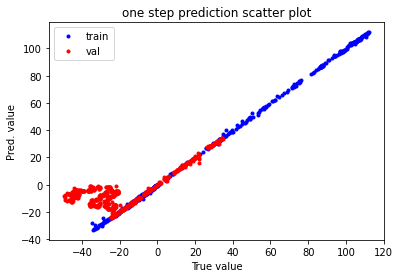

In [54]:
from src.visualization import mdl_scatter_pred as msp
msp.draw_non_recursive(m1)

Saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/ML_predicted_non_recursive.png


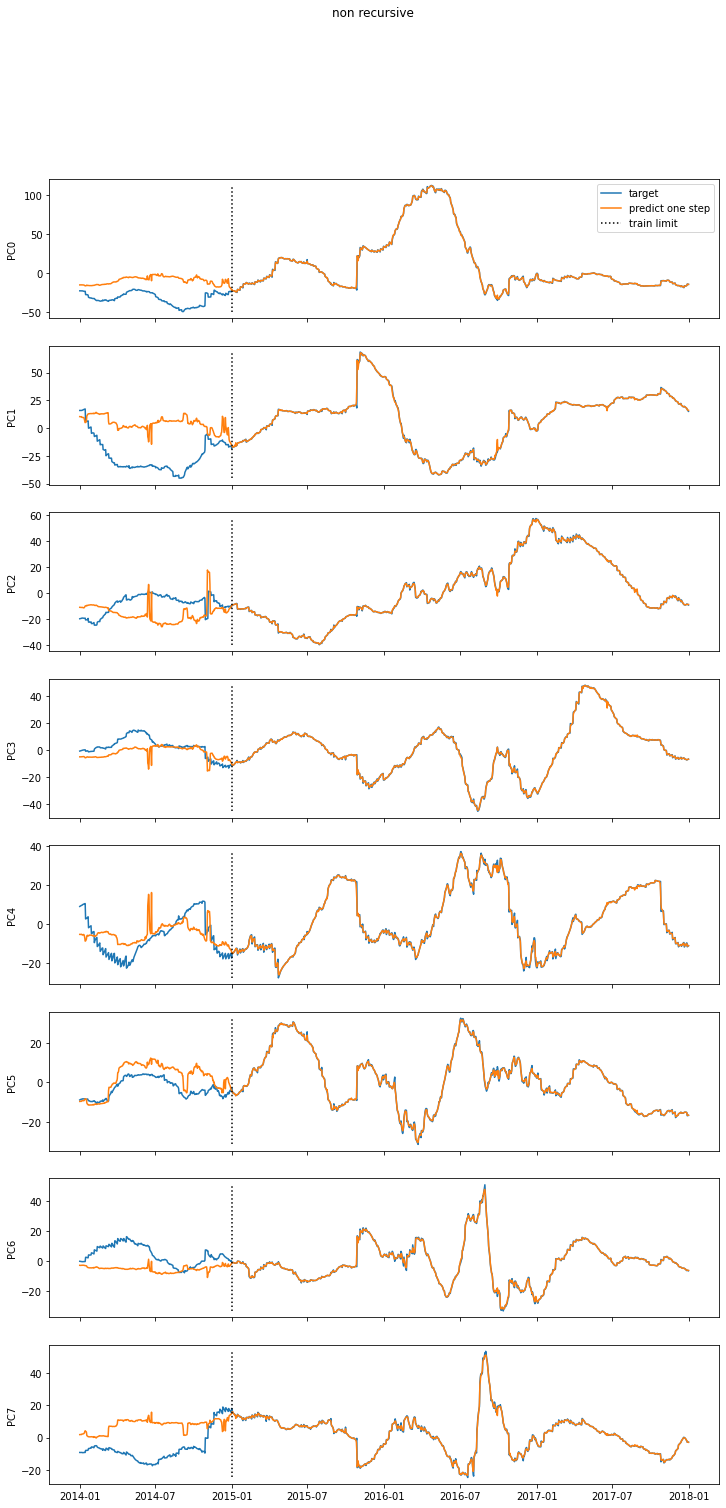

In [55]:
from src.visualization import mdl_non_recursive
mdl_non_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True)

### Plot evaluation ML model

In [56]:
from src.visualization import mdl_recursive
mdl_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True, showfig=True)

Values predicted with following method: sequence recursive.
                Use corresponding plotting function to visualize results


Values predicted with following method: sequence recursive.
                Use corresponding plotting function to visualize results


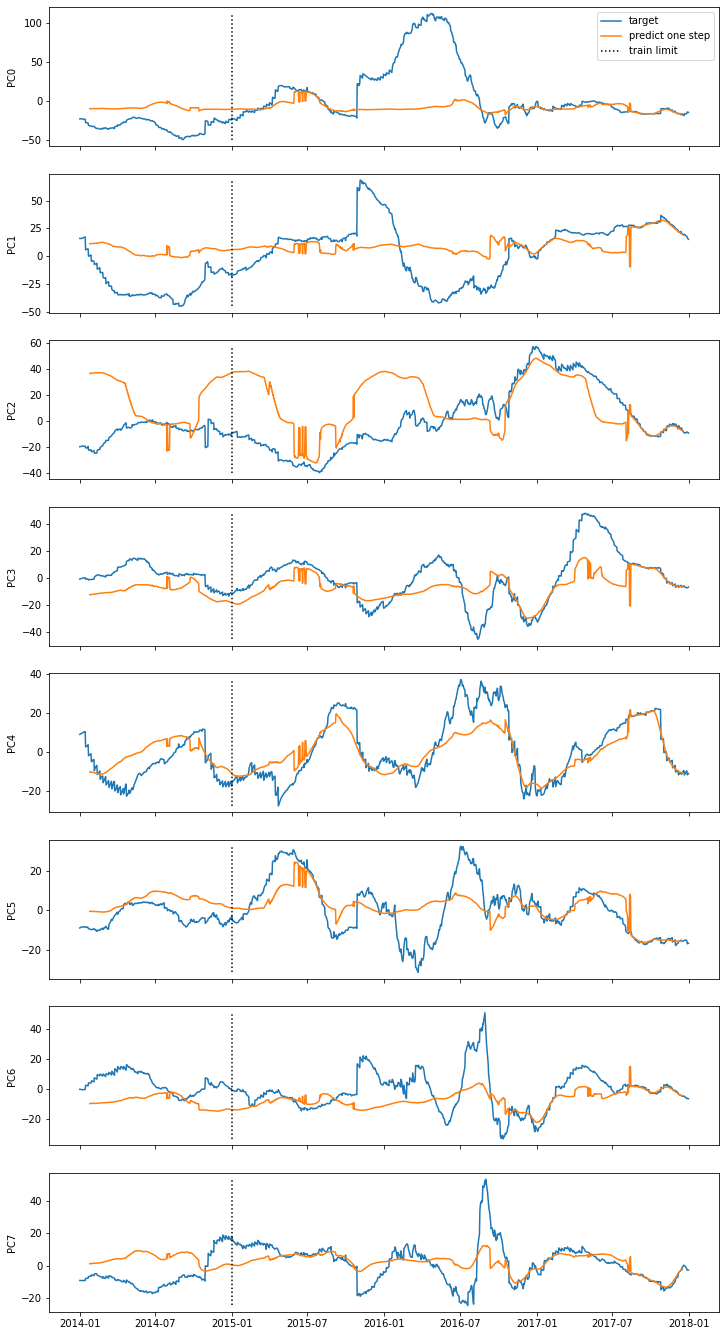

In [57]:
mdl_recursive.draw(m1, force=True, showfig=True)

----

Please specify folder for save .png


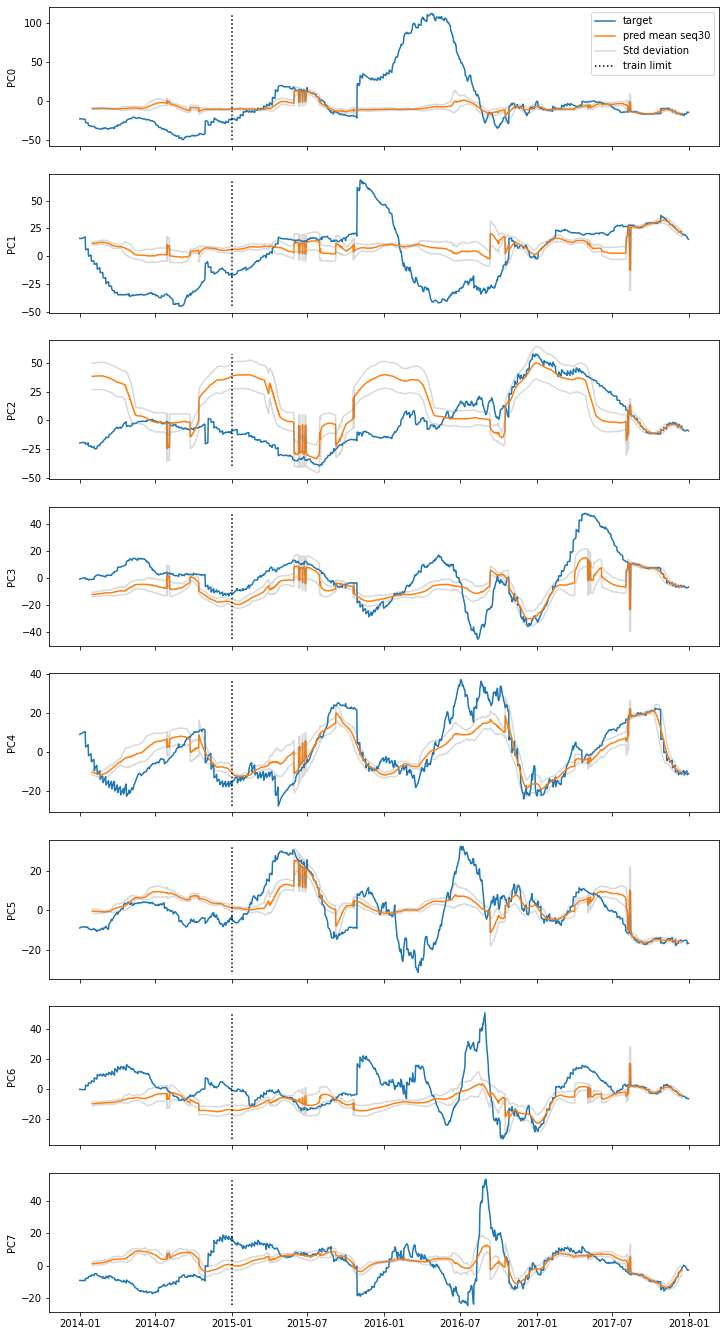

In [58]:
from src.visualization import mdl_recursive_sequence as mrs
# mrs.draw_seq(m1, savefig=True)
mrs.draw(m1, max_plot=8, savefig=True)

In [59]:
m1.yrec.shape

(1460, 8)

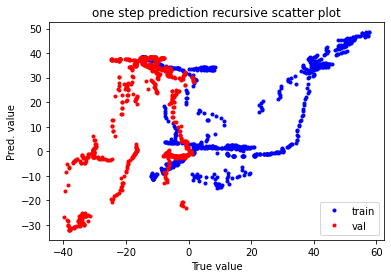

In [60]:
msp.draw_recursive(m1,2)

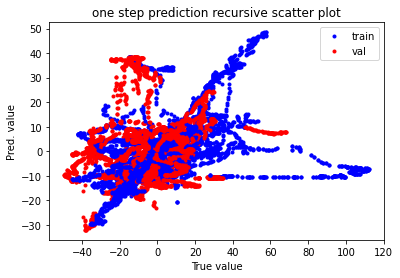

todo


In [61]:
msp.draw_recursive_allfeat(m1, savefig=True)

### Evaluation variables importance

In [62]:
# depreciated : use visu_mdl_importance
# m1.plot_importance_var(0, savefig=True)

In [63]:
from src.visualization import visu_mdl_importance

In [64]:
from importlib import reload
reload(visu_mdl_importance);

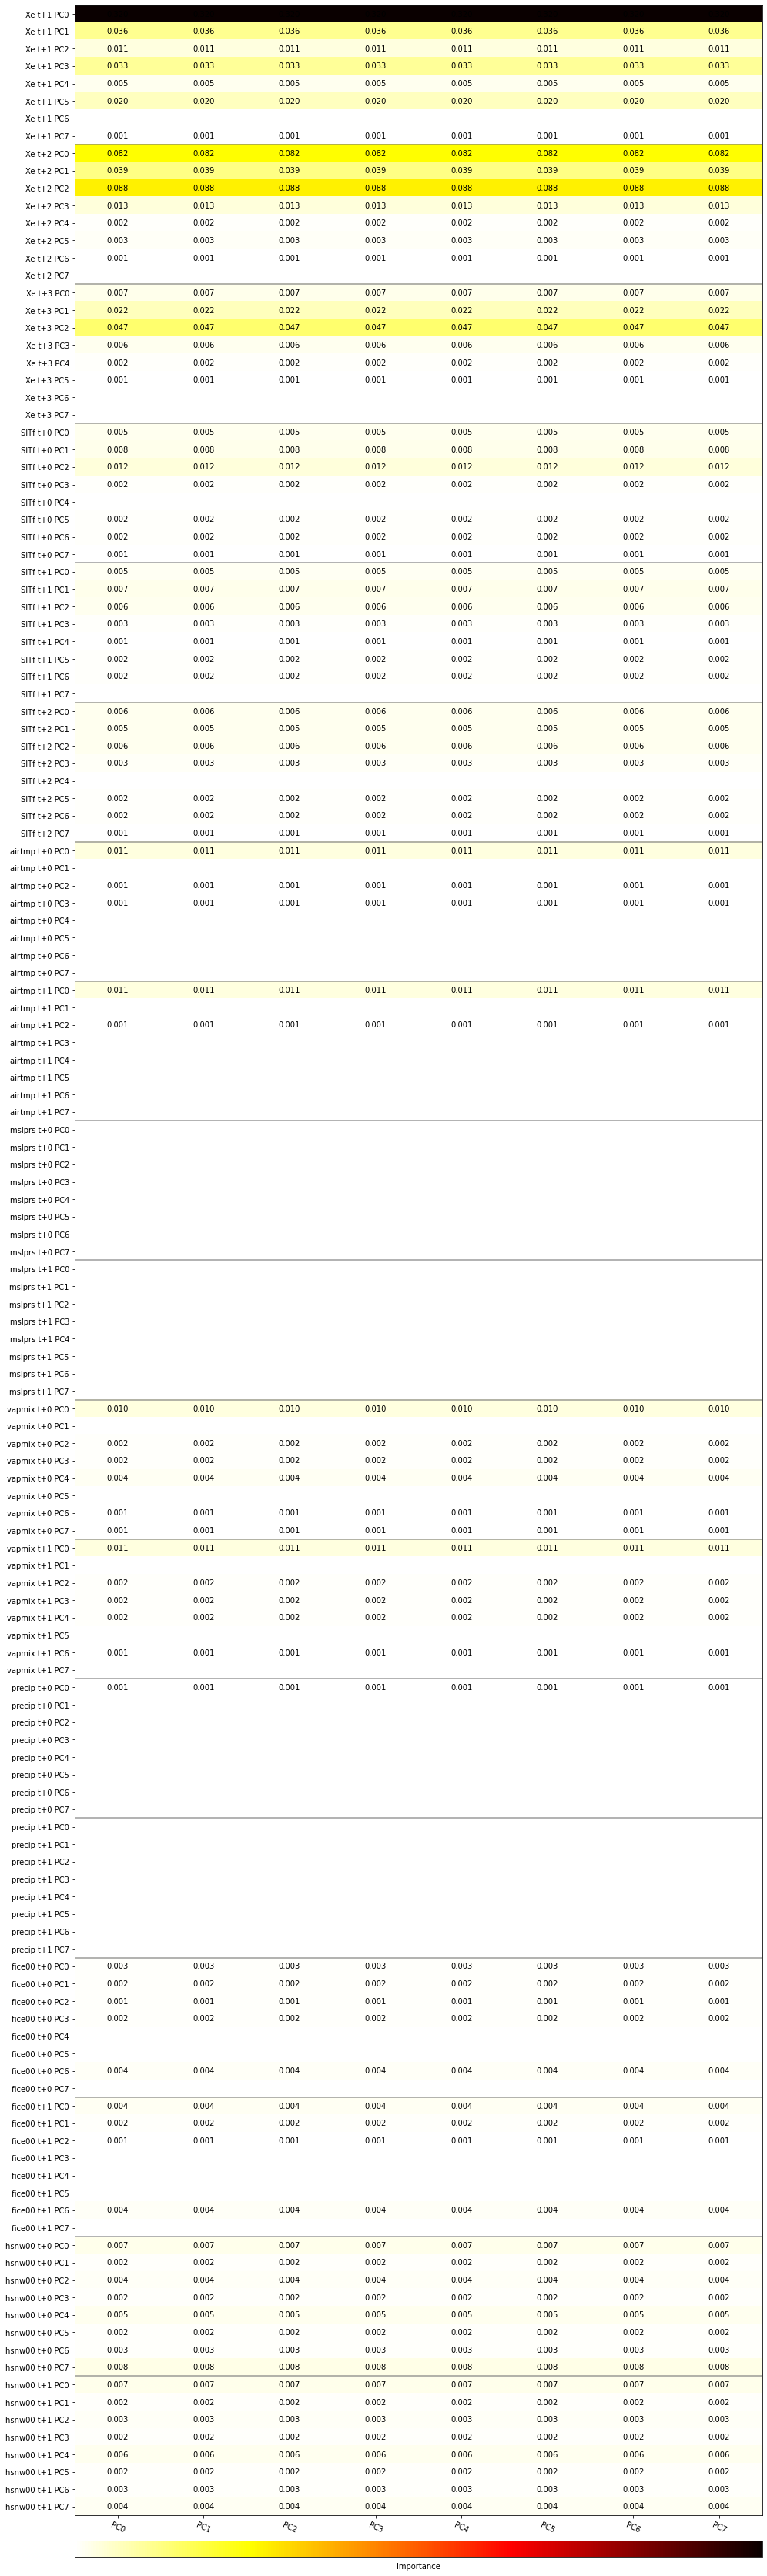

In [65]:
visu_mdl_importance.plot_importance_var_allpca(m1, savefig=False, showfig=True)

In [66]:
visu_mdl_importance.plot_importance_var(m1, 4, savefig=True, showfig=False)

Saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/importance_PC4.png


----

In [68]:
# put 0 instead of nan
yrr = m1.yrec.copy()
yrr[np.where(np.isnan(m1.yrec))] = 0

m1.yrec = yrr

In [69]:
# permutation test
m1.compute_permutation_imp(redo=True)

In [ ]:
# depreciated + removed : use mdl_permu_test
#  m1.draw_permu_test(max_plot=8,savefig=True)

KeyError: 'pc4'

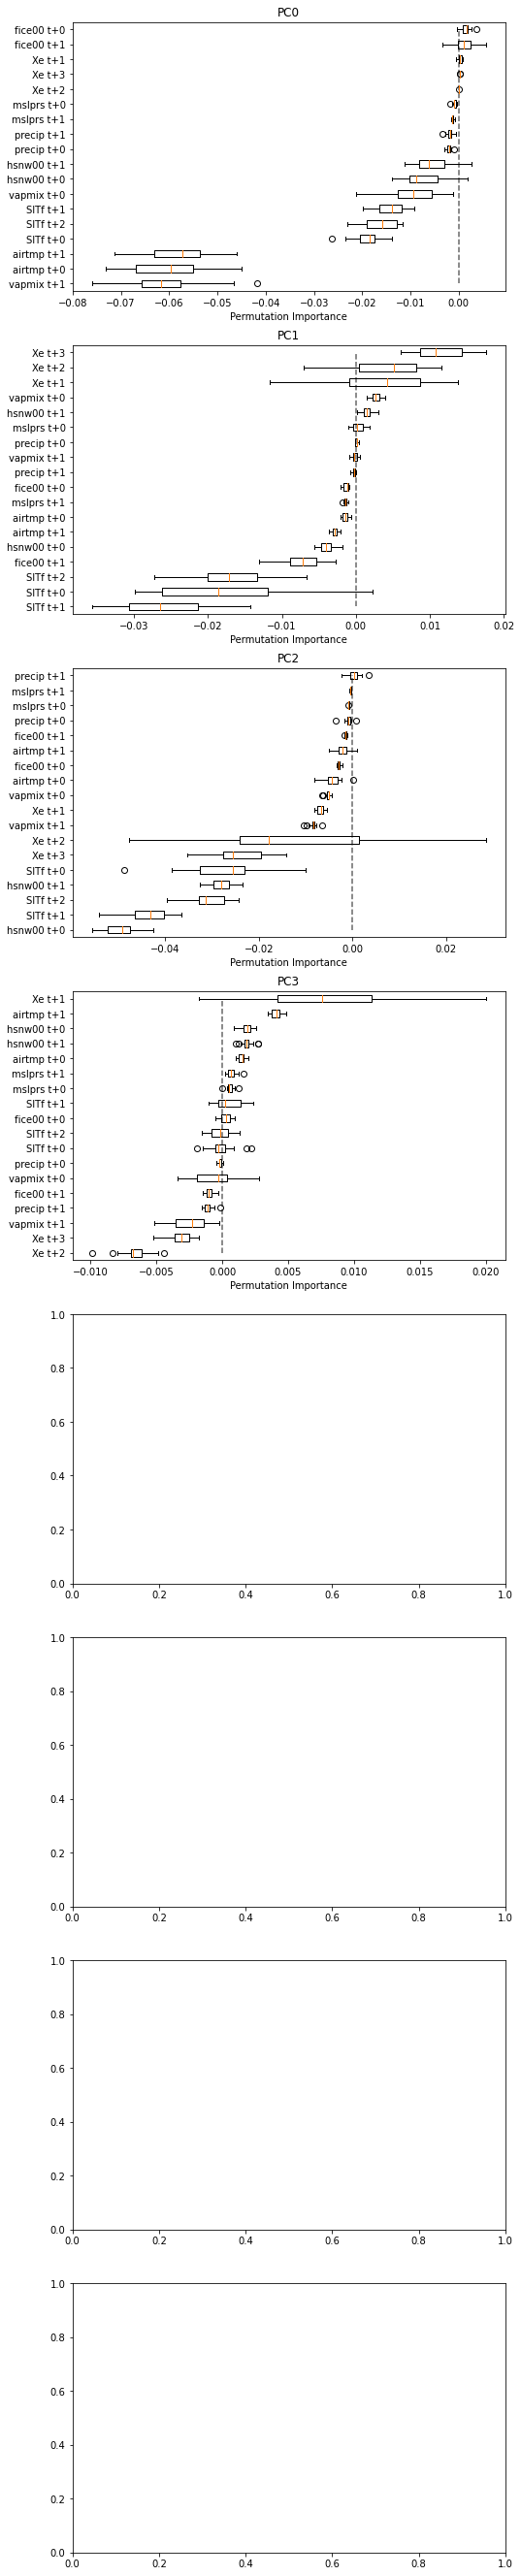

In [71]:
from src.visualization import mdl_permu_test
mdl_permu_test.draw_permu_test(m1, max_plot = 8, savefig=True)

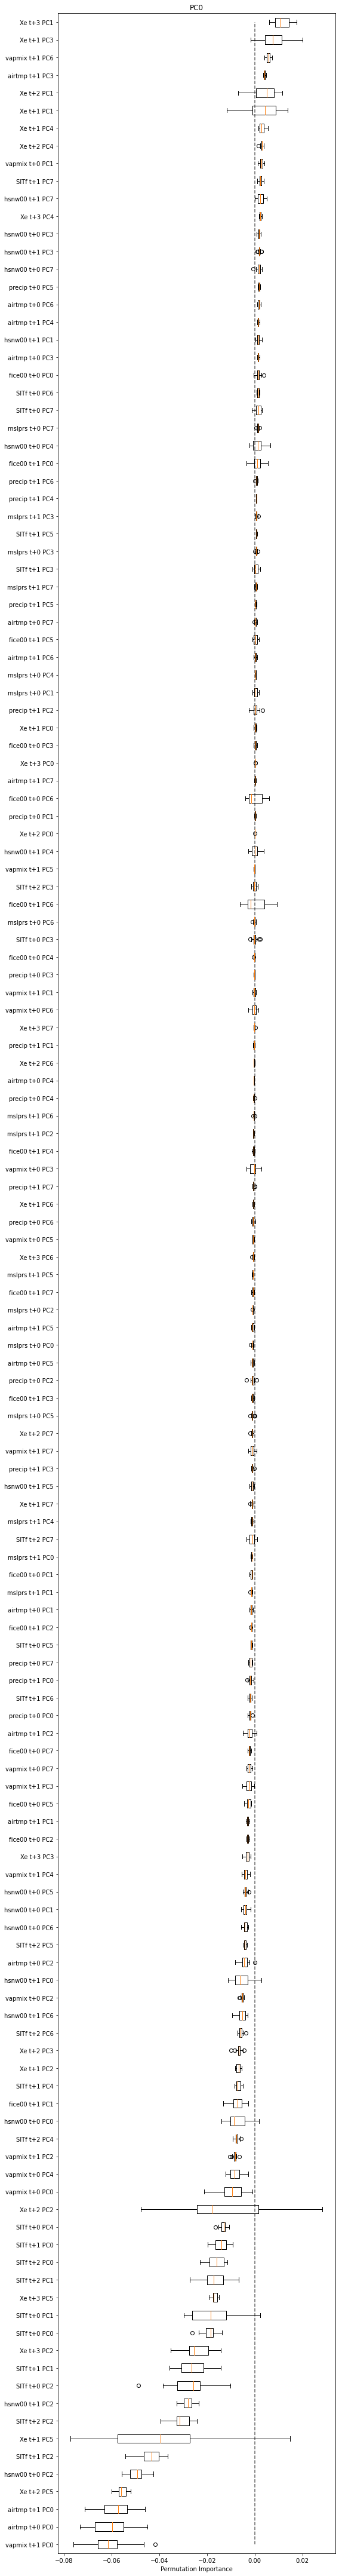

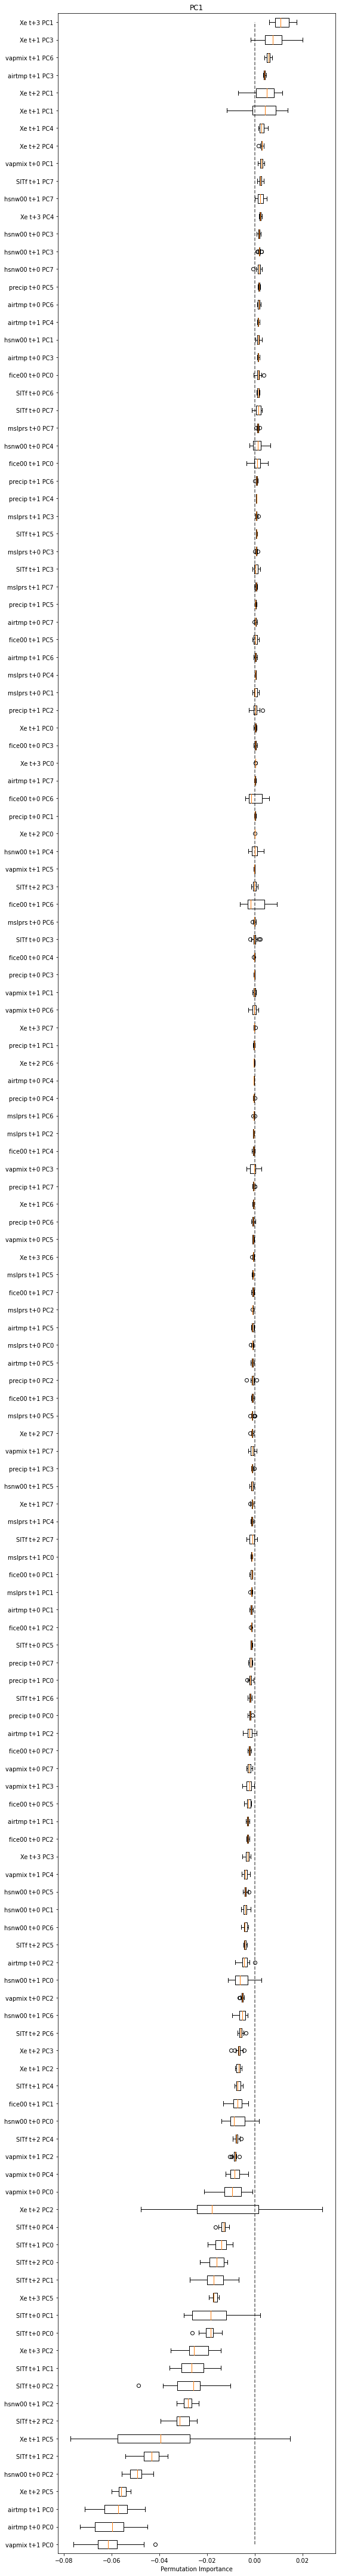

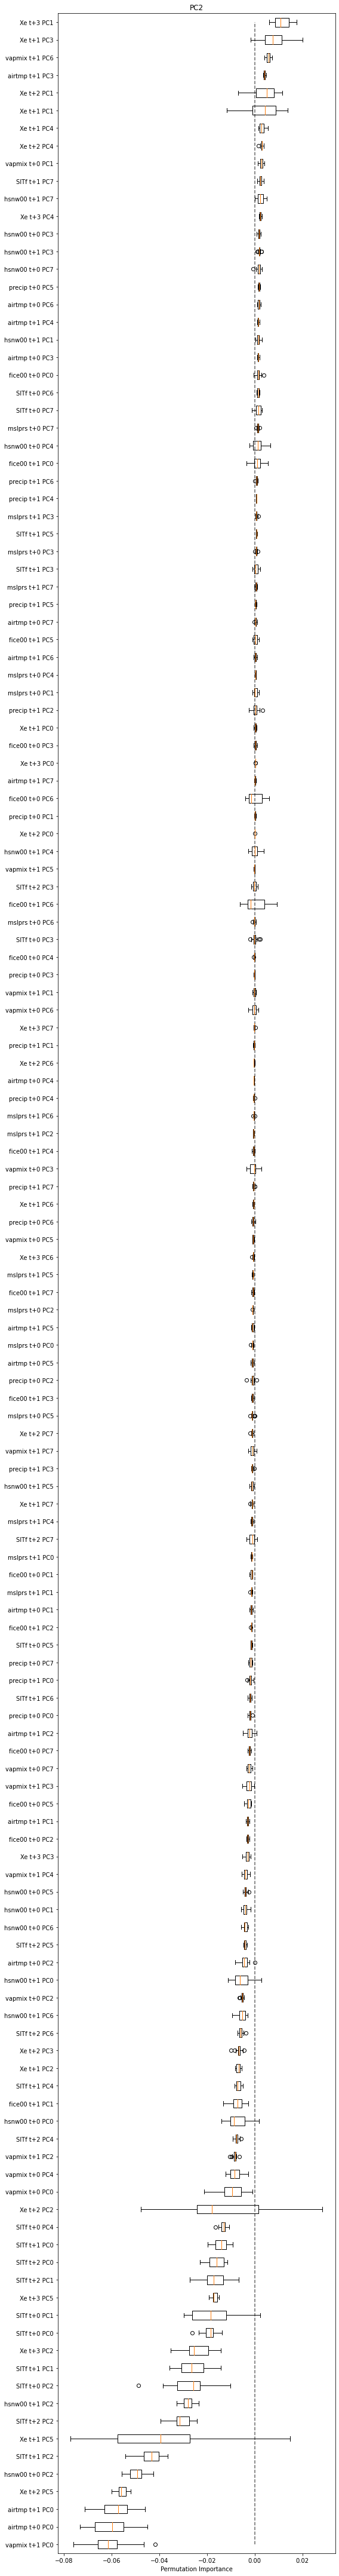

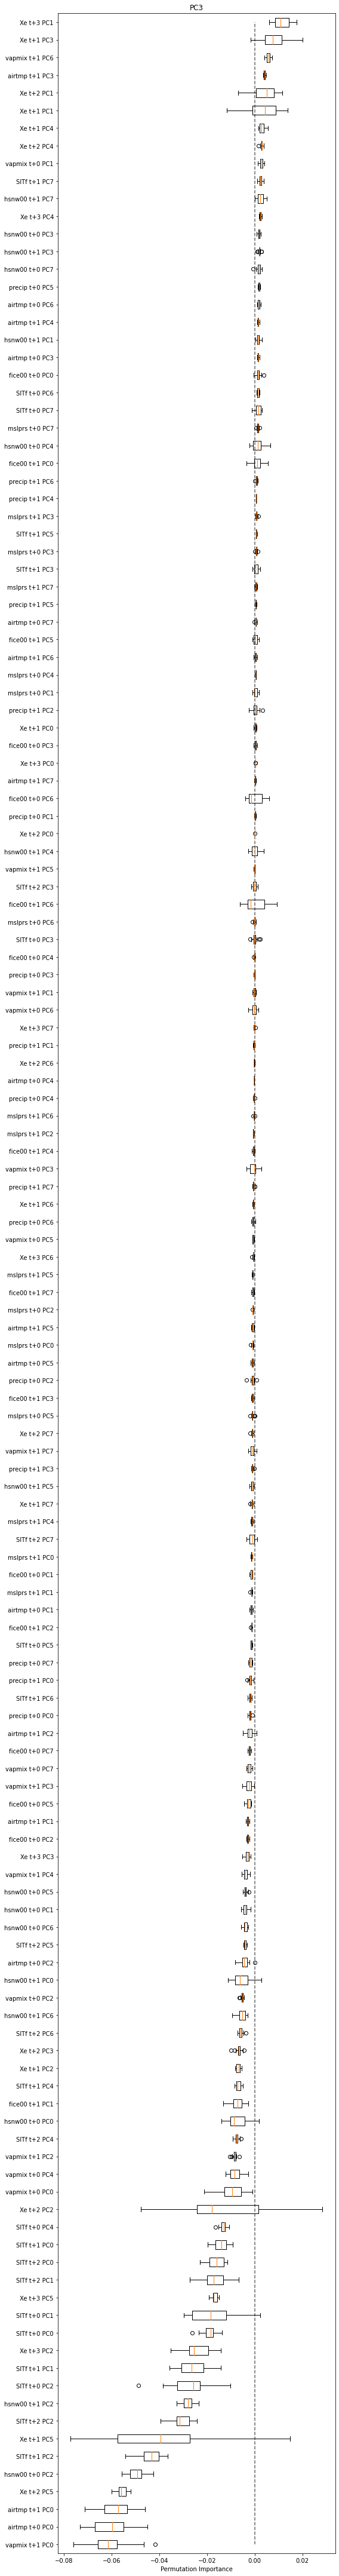

KeyError: 'pc4'

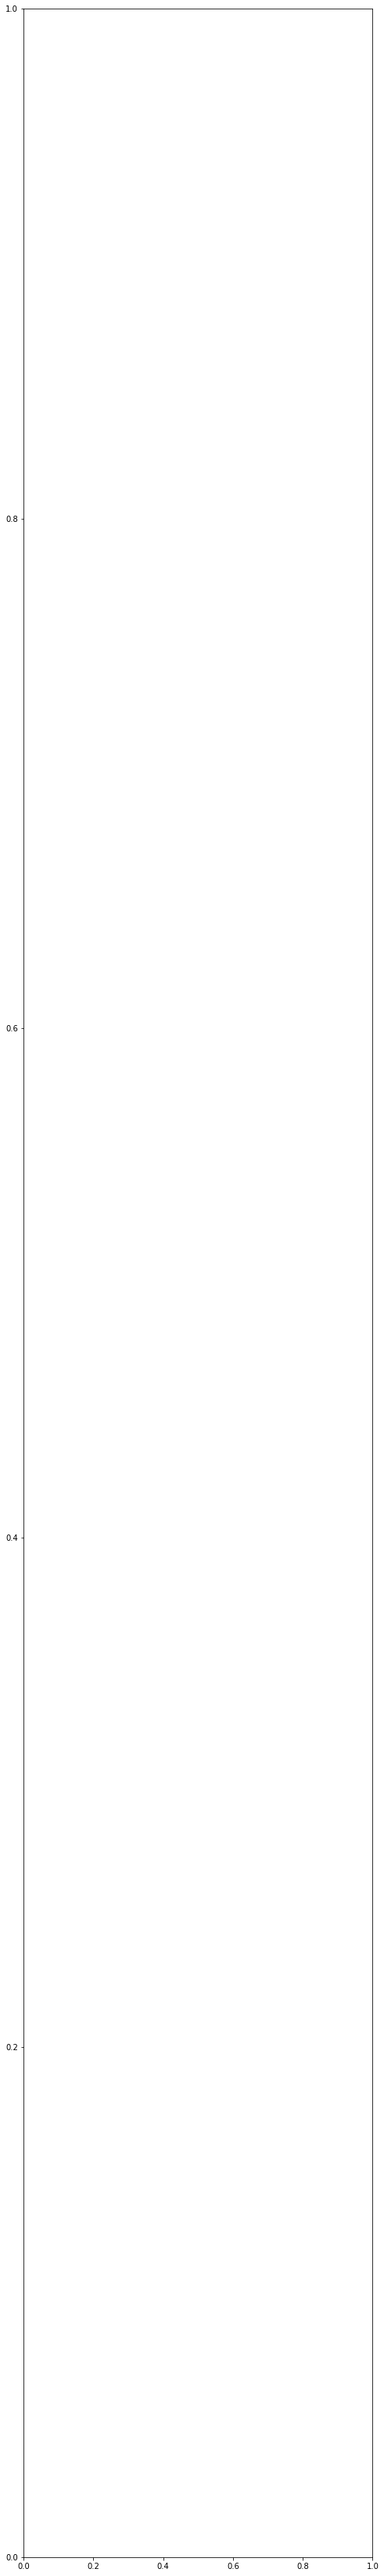

In [72]:
for i in range(8):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, savefig=False, showfig=True)

---------

### Reconstruct values 

In [ ]:
# PCA from values predicted by ML algo recursive (yrec)

PCA_est =  np.zeros_like(PCs_e.values)
PCA_est[:-1] = m1.yrec[::-1]
# PCA_est[:-1] = yrec[::-1][:,12:]
PCA_est = xr.DataArray(PCA_est, dims=['rdim','comp'])

In [ ]:
# Reconstruction 
Xc = xr.dot(EOF2d_e,PCA_est)+ mu_e


In [ ]:
# reshape to get time first
Xc = Xc.transpose('rdim', 'jdim', 'idim')

-----

### Get mean error and apply simplest correction 

In [ ]:
from src.feature_extraction import mean_error

In [ ]:
from importlib import reload
reload(mean_error);

In [ ]:
# mean on training period
Xe_train = Xe.isel(rdim=slice(ntest+nval,ntest+nval+ntrain))
chrono_train = chrono.iloc[-ntrain:]  # oui

In [ ]:
Xe_mm = mean_error.monthly(chrono_train, Xe_train)

In [ ]:
Xf_mc = mean_error.apply_mean_correction(chrono, Xf, Xe_mm)

In [ ]:
# compute RMSE of monthly mean - forecast
# to get the RMSE of the simplest correction (upper bound)
RMSE_mc = np.sqrt((np.square(Xf_mc.isel(rdim=slice(None,ntest))-Xf.isel(rdim=slice(None,ntest)))).mean(dim='rdim'))
RMSE_mc_av = RMSE_mc.mean()

In [ ]:
RMSE_mc_av.values;

In [ ]:
# Xmc_start = Xf_mc.isel(rdim=slice(None,nyr*ntest))
# RMSE_mc_t = np.sqrt((np.square(Xmc_start-Xe_start)).mean(dim=('idim','jdim')))

In [ ]:
# fig, ax = plt.subplots(ncols=1, nrows=12,figsize=(8,6*12))
# for i in range(12):
#     Xe_mm[i].plot(ax=ax[i])

-----

### Plot reconstructed values 

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
fig.suptitle(f'{target_field} error {chrono.iloc[idate]}')
Xc.isel(rdim=idate).plot(ax=ax[0],vmin=-2, vmax=2)
ax[0].set_title(f'estimated by ML');
Xe.isel(rdim=idate).plot(ax=ax[1],vmin=-2, vmax=2)
ax[1].set_title(f'TOPAZ ass');
(Xc-Xe).isel(rdim=idate).plot(ax=ax[2], vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'));
ax[2].set_title('ML - TOPAZ');
filename = f'{target_field}_error_ML_TOPAZ_diff.png'
plt.savefig(f"{rootdir}{fig_dir}{filename}")


In [ ]:
print(f'Size of the test:{ntest}')
RMSE_corr = np.sqrt((np.square(Xc.isel(rdim=slice(None,ntest))-Xe.isel(rdim=slice(None,ntest)))).mean(dim='rdim'))


In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(21,6))
fig.suptitle('RMSE of')
RMSE_corr.plot(vmax=2, ax = ax[0])
ax[0].set_title('the corrected field (test period)');
RMSE_rece.plot(vmax=2, ax=ax[1])
ax[1].set_title('the error reconstruction (lower bound)');
RMSE_mc.plot(vmax=2, ax=ax[2])
ax[2].set_title('the monthly mean error correction (fair upper bound)');
# RMSE_e.plot(vmax=2, ax=ax[2])
# ax[2].set_title('the model (upper bound)');
filename = f'RMSE_corr_reca_a.png'
plt.savefig(f"{rootdir}{fig_dir}{filename}")

# print('\n\n TODO: upper bound = mean monthly error')

In [ ]:
RMSE_corr_av = RMSE_corr.mean()
RMSE_rece_av = RMSE_rece.mean()
RMSE_e_av = RMSE_e.mean()

In [ ]:
%%capture cap --no-stderr 
# save output to .txt file
print(f'Average of the corrected model error (lower bound):{RMSE_corr_av.values:.2f}')
print(f'Average of the model error reconstruction (lower bound):{RMSE_rece_av.values:.2f}')
print(f'Average of the model error (upper bound): {RMSE_e_av.values:.2f}')
print(f'Average of the monthly mean error correction (fair upper bound): {RMSE_mc_av.values:.2f}')

In [ ]:
# add_output_2txt(fl_out, cap)  # save output to .txt file
print(cap.stdout)

In [ ]:
nyr = 4 # 2 # number of year to plot for test

Xe_start = Xe.isel(rdim=slice(None,nyr*ntest))
Xc_start = Xc.isel(rdim=slice(None,nyr*ntest))
Xf_start = Xf.isel(rdim=slice(None,nyr*ntest))
Xt_start = Xe_start + Xf_start
Xn_start = Xc_start + Xf_start

In [ ]:
RMSE_f_t = np.sqrt((np.square(Xe_start)).mean(dim=('idim','jdim')))
RMSE_c_t = np.sqrt((np.square(Xc_start-Xe_start)).mean(dim=('idim','jdim')))

Xmc_start = Xf_mc.isel(rdim=slice(None,nyr*ntest)) - Xf.isel(rdim=slice(None,nyr*ntest)) 
RMSE_mc_t = np.sqrt((np.square(Xmc_start-Xe_start)).mean(dim=('idim','jdim')))

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(16,6))
ax.plot(chrono.iloc[:nyr*ntest], RMSE_f_t, label='forecast error')
ax.plot(chrono.iloc[:nyr*ntest], RMSE_mc_t, 'r', label='monthly mean corrected error', alpha=0.5)
ax.plot(chrono.iloc[:nyr*ntest], RMSE_c_t, label='ML corrected error')
ax.plot([chrono.iloc[ntest]]*2,[0.0, 0.60], ':k', label='train limit')
ax.legend()
plt.xticks(rotation= -25)
ax.set_ylabel(f'RMSE')
# plt.suptitle(f'forcing mean_{config["forcing_mean_days"]}d')
# filename = f'ML_RMSE_forcing_smooth_mean{config["forcing_mean_days"]}d_01.png'
filename = f'ML_RMSE_forcing_smooth_01.png'
plt.savefig(f"{rootdir}{fig_dir}{filename}")

## Show reconstructed sea-ice thickness

#### Loading Target var PCA WITH SIT assimilation
for comparison

In [ ]:
data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_SITass.pkl")
pca_a = load_data.load_pca(filename)

In [ ]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITass.nc")
Xa, mu_a, RMSE_a = load_data.load_nc(filename, target_field)

In [ ]:
# retrieve PC and EOF values
PCs_a = feature_pca.pca_to_PC(pca_a, Xa, mskok1d)

# EOF1d_f, EOF2d_f = feature_pca.compute_eof(n_components, Xf, pca_f, mskok)

In [ ]:
# Reconstruction from PCA
# Xf_rec = xr.dot(EOF2d_f,PCs_f) + mu_f

# RMSE for comparison with RMSE predicted by ML
# RMSE_recf = np.sqrt((np.square(Xf_rec-Xf)).mean(dim='rdim'))

-----

## Plot temporal reconstruction

In [ ]:
savefig = True
Xf_mt = np.mean(Xf, axis=(1,2))  # forecast mean temporal
Xa_mt = np.mean(Xa, axis=(1,2))  # assimilated mean temporal

In [ ]:
Xc.shape

In [ ]:
# plot sea ice thickness
# idealement ajouter les donnees in situ

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(16,6))
ax.plot(chrono.iloc[:], Xf_mt, label='TOPAZ no ass')
ax.plot(chrono.iloc[:], Xa_mt, '--', label='TOPAZ ass')

# SIT corrected
ax.plot(chrono.iloc[:], np.nanmean(Xf_mc, axis=(1,2)), 'r', label='Mean correction', alpha=.7)
ax.plot(chrono.iloc[:], Xf_mt + np.mean(Xc, axis=(1,2)), 'k', label='ML corrected')

ax.set_ylabel(f'{target_field} (m)')
ax.plot([chrono.iloc[ntest]]*2,[.30,1.60], ':k', label='train limit')
ax.legend()
plt.xticks(rotation= -25)

if savefig:
    filename = f'TOPAZ_{target_field}_timeserie.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}")
    print(f'Figure saved as: {filename}')

In [ ]:
# erreur mensuelle moyenne en tous points
# -> erreur la plus simple (et meilleure que le hasard)

# permet d'evaluer la capacite de notre algorithme a predire l'erreur résiduelle 

# evaluation en 2d !


## Plot spatial reconstruction

for idate

In [ ]:
from src.visualization import visualize_error

In [ ]:
visualize_error.spatial_reconstruct(Xf, Xf_mc, Xc, Xa, chrono, 100, showfig=True)

In [ ]:
odir = 'Leo/results/spatial_reconstruct/figures/'
# visualize_error.spat_reco_save_all(Xf, Xf_mc, Xc, Xa, chrono, rootdir, odir)

### Spatiale distribution of error

In [ ]:
from importlib import reload
reload(visualize_error);

In [ ]:
visualize_error.hist(Xf, Xf_mc, Xc, Xa, chrono, 600, showfig=True)

In [ ]:
xf = np.mean(Xf, axis=(0))
xc = np.mean(Xc, axis=(0)) + xf
xfmc = np.mean(Xf_mc, axis=(0))
xa = np.mean(Xa, axis=(0))

In [ ]:
visualize_error.hist_mean(xf, xfmc, xc, xa, chrono, showfig=True)

In [ ]:
Xa.shape

In [ ]:
Xc.T.shape

In [ ]:
xf_mm = mean_error.monthly(chrono, Xf)
xa_mm = mean_error.monthly(chrono, Xa)

In [ ]:
xc_mm = mean_error.monthly(chrono, Xc)
xfmc_mm = mean_error.monthly(chrono, Xf_mc)

In [ ]:
xf_mm.shape

In [ ]:
from importlib import reload
reload(visualize_error);

In [ ]:
visualize_error.hist_monthly_4(xf_mm, xfmc_mm, xc_mm+xf_mm , xa_mm, chrono, showfig=True)

In [ ]:
visualize_error.hist_monthly(xf_mm, xfmc, xc, xa, chrono, showfig=True)

In [ ]:
visualize_error.hist_monthly(xa_mm, xfmc, xc, xa, chrono, showfig=True)

In [ ]:
visualize_error.hist_monthly(xfmc_mm, xfmc, xc, xa, chrono, showfig=True)

In [ ]:
visualize_error.hist_monthly(xc_mm+xf_mm, xfmc, xc, xa, chrono, showfig=True)